In [20]:
import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DATA PREP: 

1. Merge LD data and FRP into one dataframe


2. Add Family column


3. Convert information in the Mean Onset column into a format that's code friendly

In [21]:
def mergeLDFRP(dfDD, dfLD, species, colstokeep):  
    
    """
    dfDD: dataframe containing DD data
    dfLD: dataframe containing LD data
    species: list of species to conduct PCA on 
    colstokeep: list of measures/columns of interest
    """
    
    dfDD = pd.read_csv(str(dfDD))
    dfLD = pd.read_csv(str(dfLD))
    
    
    dfLD = dfLD.drop(columns = ["LombSc period"])
    dfDDfrp = dfDD[["LombSc period"]]
    concat = pd.concat([dfLD, dfDDfrp], axis=1)
    
    global dfi
    dfi = concat[concat["Specie Name"].isin(species)]
    dfi.drop(dfi.columns.difference(colstokeep), 1, inplace = True)

In [22]:
mergeLDFRP("all_spider_summary_DD.csv", "all_spider_summary_LD.csv", ['Micrathena mitrata', "Metazygia wittfeldae"],['Specie Name','LombSc period','Spider ID', "Mean activity onset", "DiNoc ratio"] )

In [23]:
def family(row):  
    """
    add more if/return statements to conduct PCA on more species
    """
    
    if row["Specie Name"] == 'Micrathena mitrata':
        return "Theridiidae Tangle-Web"
    if row["Specie Name"] == "Metazygia wittfeldae":
        return "Araneidae Orb-Weaver"

In [24]:
dfi['Family'] = dfi.apply (lambda row: family(row), axis=1)

In [25]:
def converttohours():
    global dfi
    xpd = [pd.to_datetime(i).time() for i in dfi["Mean activity onset"].values]
    ot = [i.hour + i.minute * (1/60) for i in xpd]
    dfi["Ot Mean Onset"] = ot

In [26]:
converttohours()

In [43]:
# display first 5 rows 
dfi.head(5)

,Specie Name,Spider ID,Mean activity onset,DiNoc ratio,LombSc period,Family,Ot Mean Onset
311,Metazygia wittfeldae,Monitor 1 Spider 1,19:27:00,-1.948302,22.011150,Araneidae Orb-Weaver,19.450000
312,Metazygia wittfeldae,Monitor 1 Spider 2,19:31:00,-1.968857,21.316001,Araneidae Orb-Weaver,19.516667
313,Metazygia wittfeldae,Monitor 1 Spider 3,19:21:00,-1.955786,24.453386,Araneidae Orb-Weaver,19.350000
314,Metazygia wittfeldae,Monitor 1 Spider 4,19:41:00,-1.966046,24.676897,Araneidae Orb-Weaver,19.683333
315,Metazygia wittfeldae,Monitor 1 Spider 5,19:31:00,-1.945309,21.316001,Araneidae Orb-Weaver,19.516667


#### PCA calculations

1. separate by family then append (helps get around PCA component nuances)


2. create finalDf dataframe with principal component 1 and 2 info


3. plot 

In [51]:
dfthe = dfi[dfi.Family == "Theridiidae Tangle-Web"]  #tangle-web df
dfara = dfi[dfi.Family == "Araneidae Orb-Weaver"]  #orb-weaver df
dfi2 = dfthe.append(dfara, ignore_index = True)

In [56]:
features = ["LombSc period","DiNoc ratio", "Ot Mean Onset"]
x = dfi2.loc[:, features].values
y = dfi2.loc[:,['Specie Name']]
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
              , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, dfi2], axis = 1)
#display(finalDf)

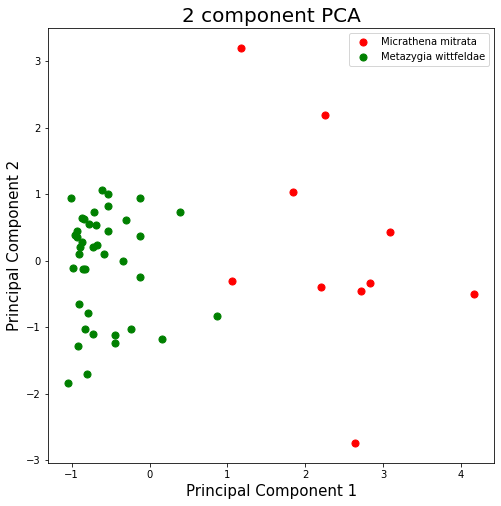

In [59]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Micrathena mitrata', 'Metazygia wittfeldae']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Specie Name'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)